# Deterministic vs Stochastic estimator comparison on runtime logs

This notebook will focus on comparing deterministic to stochastic thresholding in terms of performane. For the stochastic case, we'll consider the *Straight-Through v1* and *Slope-Annealing (rate=0.1)* estimators, since we saw that those two performed the best. For a fair comparison we'll examine only the vanilla (i.e. fully-trained) deterministic estimator.

We'll use the same experimental procedure as in the previous notebooks:


> Runtime logs are meant to study a model's **convergence**, i.e. *how many epochs does it take for a model to converge?*, *does it experience heavy oscillations during training?*, etc. They **aren't** meant to examine the model's generalization. There are two types of runtime logs:
> 
> - **epoch** logs are the ones that are recorded **once per epoch** (usually at the end of the epoch), e.g. validation metrics.
> - **batch** logs are the ones that are recorded **once per batch** (i.e. once per model update), e.g. the model's loss.
> 
> While it is possible to examine the logs in other ways, the scope of this study involves examining the **least** amount of information that the models require to **adequately** classify. Thus we'll follow the following procedure:
> 
> 1. For each model that we want to examine, first we'll check its **validation accuracy**. Only models with sufficiently high validation accuracy, comared to the baseline, will be examined further.
> 2. They we'll check the model's **percentage of pixels hidden**. As we said we are interested in finding the least amount of information that the models require, so we'll keep the models that hide large percentage of pixels.
> 3. After filtering the models by these two conditions, we'll examine things such as the convergence speed and the stability of the model.

In [1]:
import sys
sys.path.append('..')

import warnings
warnings.filterwarnings('once')

from utils.plotting import *

%matplotlib inline

/home/thanos/.envs/dl/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/thanos/.envs/dl/lib/python3.5/site-packages/tensorflow/python/keras/backend.py:5605: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/thanos/.keras/keras.json' mode='r' encoding='UTF-8'>
  _config = json.load(open(_config_path))
/home/thanos/.envs/dl/lib/python3.5/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])


## Load the models and the baseline 

Load logs (epoch and batch) for all three model families, as well as the baseline.

In [2]:
# Baseline
baseline_loc = '../results/cifar10/seeker/default/baseline.txt'
with open(baseline_loc) as f:
    baseline = float(f.read())
print('Baseline accuracy: {:.2f}%'.format(baseline * 100))

# Deterministic
experiment_dir = '../logs/cifar10/hns/deterministic/full_training_10/'
det_epoch_logs = load_and_process_epoch_logs_from_dir(experiment_dir)
det_batch_logs = load_and_process_batch_logs_from_dir(experiment_dir)

# ST
experiment_dir = '../logs/cifar10/hns/stochastic/st1/full_training_10/'
st1_epoch_logs = load_and_process_epoch_logs_from_dir(experiment_dir)
st1_batch_logs = load_and_process_batch_logs_from_dir(experiment_dir)

# SA-1.0
experiment_dir = '../logs/cifar10/hns/stochastic/sa/rate_1.0/full_training_10/'
sa_epoch_logs = load_and_process_epoch_logs_from_dir(experiment_dir)
sa_batch_logs = load_and_process_batch_logs_from_dir(experiment_dir)

Baseline accuracy: 65.37%


W0310 16:52:01.437142 140416998639360 deprecation.py:323] From /home/thanos/.envs/dl/lib/python3.5/site-packages/tensorflow/python/summary/summary_iterator.py:68: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


## 1. Epoch logs

First, a qualitative look.

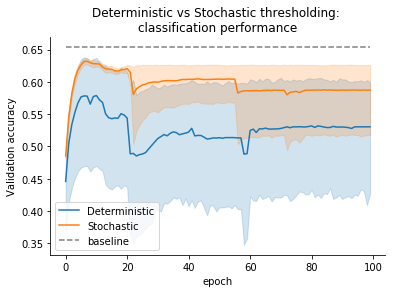

In [3]:
sns.lineplot(x='step', y='Validation accuracy', data=pd.concat(det_epoch_logs), label='Deterministic')
sns.lineplot(x='step', y='Validation accuracy', data=pd.concat(st1_epoch_logs), label='Stochastic')

plt.plot(sa_epoch_logs[0]['step'], [baseline] * len(sa_epoch_logs[0]), 
         label='baseline', c='0.5', ls='--')

plt.legend(loc='lower left')
plt.xlabel('epoch')

plt.title('Deterministic vs Stochastic thresholding: \nclassification performance')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig('figures/deterministic_stochastic_classification.pdf', bbox_inches='tight', transparent=True)

Now, to answer a few questions...

> How many models of each family managed to get score an optimal* Fidelity?  
> \* by optimal we mean that they scored at least 90% of the baseline accuracy

In [4]:
det_batch_logs_f = filter_logs_on_val_acc(det_epoch_logs, det_batch_logs, baseline)
det_epoch_logs_f = filter_logs_on_val_acc(det_epoch_logs, det_batch_logs, baseline, return_epoch=True)
st1_batch_logs_f = filter_logs_on_val_acc(st1_epoch_logs, st1_batch_logs, baseline)
st1_epoch_logs_f = filter_logs_on_val_acc(st1_epoch_logs, st1_batch_logs, baseline, return_epoch=True)
sa_batch_logs_f = filter_logs_on_val_acc(sa_epoch_logs, sa_batch_logs, baseline)
sa_epoch_logs_f = filter_logs_on_val_acc(sa_epoch_logs, sa_batch_logs, baseline, return_epoch=True)

print('Deterministic:    ', len(det_batch_logs_f))
print('Straight-Through: ', len(st1_batch_logs_f))
print('Slope-Annealing:  ', len(sa_batch_logs_f))

Deterministic:     4
Straight-Through:  9
Slope-Annealing:   9


So, while multiple deterministic models collapsed, no stochastic model did (just one  from each category scores slightly below the baseline). 

> What is the mean final accuracy of those models?  
> i.e. for the models that score at least 90% of the baseline, what is their mean final accuracy

In [5]:
print('Deterministic:    {:.2f}%'.format(np.mean([log['Validation accuracy'].iloc[-1] for log in det_epoch_logs_f])*100))
print('Straight-Through: {:.2f}%'.format(np.mean([log['Validation accuracy'].iloc[-1] for log in st1_epoch_logs_f])*100))
print('Slope-Annealing:  {:.2f}%'.format(np.mean([log['Validation accuracy'].iloc[-1] for log in sa_epoch_logs_f])*100))

Deterministic:    62.98%
Straight-Through: 62.13%
Slope-Annealing:  62.25%


When we filter out the collapsed and underperforming models, the deterministic model outperforms the stochastic ones. This means that when not collapsing, the deterministic model achieves very high performance. 

> What about peak performance?

In [6]:
print('Deterministic:    {:.2f}%'.format(np.max([log['Validation accuracy'].iloc[-1] for log in det_epoch_logs_f])*100))
print('Straight-Through: {:.2f}%'.format(np.max([log['Validation accuracy'].iloc[-1] for log in st1_epoch_logs_f])*100))
print('Slope-Annealing:  {:.2f}%'.format(np.max([log['Validation accuracy'].iloc[-1] for log in sa_epoch_logs_f])*100))

Deterministic:    64.51%
Straight-Through: 63.80%
Slope-Annealing:  65.20%


The best peak performance was achieved by the SA estimator, however this could merely be a matter of chance.

> How many epochs did they nead (in average) to converge?

In [7]:
def average_epochs(logs):
    return np.mean([log['Validation accuracy'].apply(
        lambda x: np.nan if x == log['Validation accuracy'].iloc[-1] else x).count() for log in logs])

print('Deterministic:    ', round(average_epochs(det_epoch_logs_f)))
print('Straight-Through: ', round(average_epochs(st1_epoch_logs_f)))
print('Slope-Annealing:  ', round(average_epochs(sa_epoch_logs_f)))

Deterministic:     21.0
Straight-Through:  22.0
Slope-Annealing:   33.0


The deterministic models seem a bit faster than the stochastic ones.

Another interesting thing would be to examine the convergence of the models that didn't collapse.

In [8]:
det_batch_nc, det_epoch_nc = filter_logs_no_collapse(det_batch_logs, det_epoch_logs, baseline)
st1_batch_nc, st1_epoch_nc = filter_logs_no_collapse(st1_batch_logs, st1_epoch_logs, baseline)
sa_batch_nc, sa_epoch_nc = filter_logs_no_collapse(sa_batch_logs, sa_epoch_logs, baseline)

In [9]:
print('Deterministic:    ', round(average_epochs(det_epoch_nc)))
print('Straight-Through: ', round(average_epochs(st1_epoch_nc)))
print('Slope-Annealing:  ', round(average_epochs(sa_epoch_nc)))

Deterministic:     38.0
Straight-Through:  30.0
Slope-Annealing:   34.0


Out of the models that didn't collapse, the deterministic are clearly the slowest.

> What about the fastest model?

In [10]:
def fewest_epochs(logs):
    return np.min([log['Validation accuracy'].apply(
        lambda x: np.nan if x == log['Validation accuracy'].iloc[-1] else x).count() for log in logs])

print('Deterministic:    ', fewest_epochs(det_epoch_nc))
print('Straight-Through: ', fewest_epochs(st1_epoch_nc))
print('Slope-Annealing:  ', fewest_epochs(sa_epoch_nc))

Deterministic:     19
Straight-Through:  20
Slope-Annealing:   22


It's pretty close here. All models required around $20$ epochs to converge.

## 2. Batch logs

> How many models managed to generate an optimal* Interpretability (excluding the ones that collapsed)?  
> \* over 90% of the pixels are masked

In [11]:
det_batch_nc_f = filter_logs_on_pix_hidden(det_batch_nc)
st1_batch_nc_f = filter_logs_on_pix_hidden(st1_batch_nc)
sa_batch_nc_f = filter_logs_on_pix_hidden(sa_batch_nc)

print('Deterministic:    ', len(det_batch_nc_f))
print('Straight-Through: ', len(st1_batch_nc_f))
print('Slope-Annealing:  ', len(sa_batch_nc_f))

Deterministic:     4
Straight-Through:  5
Slope-Annealing:   2


> Out of these, what is the average percentage of hidden pixels?

In [12]:
print('Deterministic:    {:.2f}%'.format(np.mean([log['percentage hidden'].iloc[-1] for log in det_batch_nc_f])))
print('Straight-Through: {:.2f}%'.format(np.mean([log['percentage hidden'].iloc[-1] for log in st1_batch_nc_f])))
print('Slope-Annealing:  {:.2f}%'.format(np.mean([log['percentage hidden'].iloc[-1] for log in sa_batch_nc_f])))

Deterministic:    92.42%
Straight-Through: 96.03%
Slope-Annealing:  97.36%


> What is the average percentage of hidden pixels out of just non-collapsed models?

In [13]:
print('Deterministic:    {:.2f}%'.format(np.mean([log['percentage hidden'].iloc[-1] for log in det_batch_nc])))
print('Straight-Through: {:.2f}%'.format(np.mean([log['percentage hidden'].iloc[-1] for log in st1_batch_nc])))
print('Slope-Annealing:  {:.2f}%'.format(np.mean([log['percentage hidden'].iloc[-1] for log in sa_batch_nc])))

Deterministic:    81.35%
Straight-Through: 68.81%
Slope-Annealing:  67.91%


Deterministic models seem to be better at hiding pixels. The collapse rarely and hide a large amound of pixels. Interestingly ST did very good in this category!


> What is the highest percentage of hidden pixels?

In [14]:
print('Deterministic:    {:.2f}%'.format(np.max([log['percentage hidden'].iloc[-1] for log in det_batch_nc])))
print('Straight-Through: {:.2f}%'.format(np.max([log['percentage hidden'].iloc[-1] for log in st1_batch_nc])))
print('Slope-Annealing:  {:.2f}%'.format(np.max([log['percentage hidden'].iloc[-1] for log in sa_batch_nc])))

Deterministic:    94.03%
Straight-Through: 99.77%
Slope-Annealing:  97.52%


> Out of the models that performed well on classification, how many models managed to generate a optimal* masking percentage?

In [15]:
det_batch_logs_ff = filter_logs_on_pix_hidden(det_batch_logs_f)
st1_batch_logs_ff = filter_logs_on_pix_hidden(st1_batch_logs_f)
sa_batch_logs_ff = filter_logs_on_pix_hidden(sa_batch_logs_f)

print('Deterministic:    ', len(det_batch_logs_ff))
print('Straight-Through: ', len(st1_batch_logs_ff))
print('Slope-Annealing:  ', len(sa_batch_logs_ff))

Deterministic:     1
Straight-Through:  4
Slope-Annealing:   2


Not much difference here, however if you recall from the stochastic estimator comparison notebook, the stochastic estimators managed to find sub-optimal solutions instead of fully collapsing, which is a plus. ST seems the best at this task.

> Out of these, what is the average percentage of hidden pixels?

In [16]:
print('Deterministic:    {:.2f}%'.format(np.mean([log['percentage hidden'].iloc[-1] for log in det_batch_logs_ff])))
print('Straight-Through: {:.2f}%'.format(np.mean([log['percentage hidden'].iloc[-1] for log in st1_batch_logs_ff])))
print('Slope-Annealing:  {:.2f}%'.format(np.mean([log['percentage hidden'].iloc[-1] for log in sa_batch_logs_ff])))

Deterministic:    94.03%
Straight-Through: 95.09%
Slope-Annealing:  97.36%


Here too, stochastic estimators converge to better overall solutions.

> What is the highest percentage of hidden pixels?

In [17]:
print('Deterministic:    {:.2f}%'.format(np.max([log['percentage hidden'].iloc[-1] for log in det_batch_logs_ff])))
print('Straight-Through: {:.2f}%'.format(np.max([log['percentage hidden'].iloc[-1] for log in st1_batch_logs_ff])))
print('Slope-Annealing:  {:.2f}%'.format(np.max([log['percentage hidden'].iloc[-1] for log in sa_batch_logs_ff])))

Deterministic:    94.03%
Straight-Through: 96.37%
Slope-Annealing:  97.52%


The highest two models are the stochastic ones, again. 

> How many steps did it take these models, on average, to converge?

In [18]:
def average_iterations(logs):
    final_iters = [log[log['loss regulator'] < 0.15].index.min() for log in logs]
    max_iters = logs[0]['step'].iloc[-1]
    true_iters = np.nan_to_num(final_iters, nan=max_iters)
    return np.mean(true_iters)

print('Deterministic:    ', round(average_iterations(det_batch_nc)))
print('Straight-Through: ', round(average_iterations(st1_batch_nc)))
print('Slope-Annealing:  ', round(average_iterations(sa_batch_nc)))

Deterministic:     1525.0
Straight-Through:  863.0
Slope-Annealing:   1364.0


The stochastic models were significantly faster than the deterministic ones. This is because some of the deterministic models didn't even manage to converge at all in time. ST is much faster than the rest.

> How many models didn't converge at all?

In [19]:
print('Deterministic:    ', np.sum(np.isnan([log[log['loss regulator'] < 0.15].index.min() for log in det_batch_nc])))
print('Straight-Through: ', np.sum(np.isnan([log[log['loss regulator'] < 0.15].index.min() for log in st1_batch_nc])))
print('Slope-Annealing:  ', np.sum(np.isnan([log[log['loss regulator'] < 0.15].index.min() for log in sa_batch_nc])))

Deterministic:     0
Straight-Through:  0
Slope-Annealing:   0


In [20]:
def fewest_iterations(logs):
    return np.nanmin([log[log['loss regulator'] < 0.15].index.min() for log in logs])

print('Deterministic:    ', fewest_iterations(det_batch_nc))
print('Straight-Through: ', fewest_iterations(st1_batch_nc))
print('Slope-Annealing:  ', fewest_iterations(sa_batch_nc))

Deterministic:     711
Straight-Through:  824
Slope-Annealing:   891


The fastest model was a deterministic one.

Let's see this visually. The best model was identified empirically by using `plot_all_logs(xxx_batch_logs, column_name='percentage hidden')`.

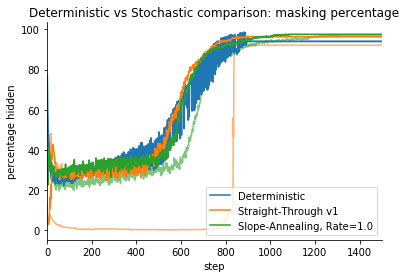

In [21]:
fancy_plot(det_batch_logs_ff, 'percentage hidden', 0, color='C0', label='Deterministic')
fancy_plot(st1_batch_logs_ff, 'percentage hidden', 2, color='C1', label='Straight-Through v1')
fancy_plot(sa_batch_logs_ff, 'percentage hidden', 1, color='C2', label='Slope-Annealing, Rate=1.0')

plt.title('Deterministic vs Stochastic comparison: masking percentage')
plt.legend(loc='lower right')
plt.xlim([0, 1500])

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

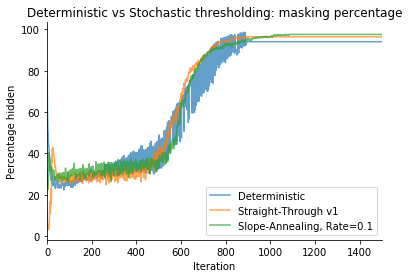

In [22]:
plt.plot(det_batch_logs_ff[0]['step'], det_batch_logs_ff[0]['percentage hidden'],color='C0', label='Deterministic', alpha=0.7)
plt.plot(st1_batch_logs_ff[2]['step'], st1_batch_logs_ff[2]['percentage hidden'], color='C1', label='Straight-Through v1', alpha=0.7)
plt.plot(sa_batch_logs_ff[1]['step'], sa_batch_logs_ff[1]['percentage hidden'], color='C2', label='Slope-Annealing, Rate=0.1', alpha=0.7)

plt.xlim([0, 1500])
plt.legend(loc='lower right')
plt.title('Deterministic vs Stochastic thresholding: masking percentage')
plt.xlabel('Iteration')
plt.ylabel('Percentage hidden')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

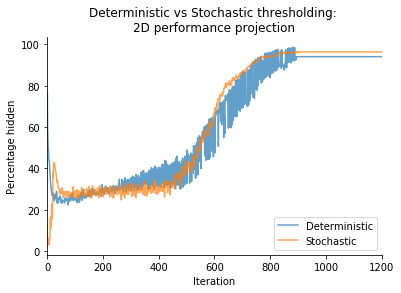

In [23]:
plt.plot(det_batch_logs_ff[0]['step'], det_batch_logs_ff[0]['percentage hidden'],color='C0', label='Deterministic', alpha=0.7)
plt.plot(st1_batch_logs_ff[2]['step'], st1_batch_logs_ff[2]['percentage hidden'], color='C1', label='Stochastic', alpha=0.7)

plt.xlim([0, 1200])
plt.legend(loc='lower right')
plt.title('Deterministic vs Stochastic thresholding: \n2D performance projection')
plt.xlabel('Iteration')
plt.ylabel('Percentage hidden')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig('figures/deterministic_stochastic_masking.pdf', bbox_inches='tight', transparent=True)

It is evident that, while the deterministic models converge faster, the stochastic ones are both more stable and converge to better overall solutions.

Now, we'll check the total loss of the models (this is one of the most reliable metrics as it combines both classification and masking performance).

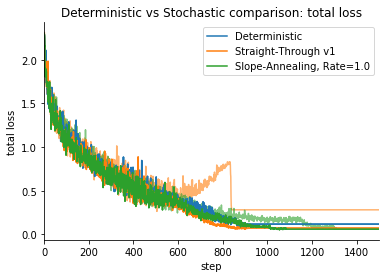

In [24]:
fancy_plot(det_batch_logs_ff, 'total loss', 0, color='C0', label='Deterministic')
fancy_plot(st1_batch_logs_ff, 'total loss', 2, color='C1', label='Straight-Through v1')
fancy_plot(sa_batch_logs_ff, 'total loss', 1, color='C2', label='Slope-Annealing, Rate=1.0')

plt.title('Deterministic vs Stochastic comparison: total loss')
plt.legend(loc='upper right')
plt.xlim([0, 1500])

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

Finally, the loss regulator (i.e. alpha) provides a look into the convergence of the models.

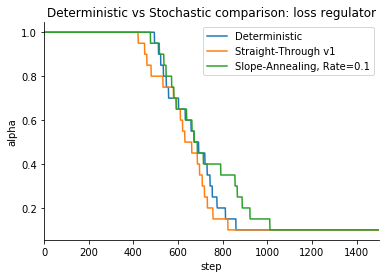

In [25]:
plt.plot(det_batch_logs_ff[0]['step'], det_batch_logs_ff[0]['loss regulator'], label='Deterministic')
plt.plot(st1_batch_logs_ff[2]['step'], st1_batch_logs_ff[2]['loss regulator'], label='Straight-Through v1')
plt.plot(sa_batch_logs_ff[1]['step'], sa_batch_logs_ff[1]['loss regulator'], label='Slope-Annealing, Rate=0.1')

plt.xlim([0, 1500])
plt.title('Deterministic vs Stochastic comparison: loss regulator')
plt.ylabel('alpha')
plt.xlabel('step')
plt.legend()

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

Interestingly, the fastest deterministic model isn't much faster than the fastest stochastic one.

### Some additional questions

> How many models collapsed to not masking\*?   
  \*normally this would constitute as 0% masking percentage, but we'll consider anything below 10% a collapse as well 

In [26]:
def collapse_zero_mask(batch_logs):
    return sum([log['percentage hidden'].iloc[-1] < 10 for log in batch_logs])

print('Deterministic:    ', collapse_zero_mask(det_batch_logs))
print('Straight-Through: ', collapse_zero_mask(st1_batch_logs))
print('Slope-Annealing:  ', collapse_zero_mask(sa_batch_logs))

Deterministic:     2
Straight-Through:  1
Slope-Annealing:   2


> How many models collapsed to masking everything\*?   
  \*normally this would constitute as 100% masking percentage, but we'll consider anything above 99% a collapse as well.

In [27]:
def collapse_full_mask(batch_logs, epoch_logs):
    suspicious_masks = [log['percentage hidden'].iloc[-1] > 98.5 for log in batch_logs]
    low_acc = [log['Validation accuracy'].iloc[-1] < 0.3 * baseline for log in epoch_logs]
    return sum([m & a for m, a in zip(suspicious_masks, low_acc)])

print('Deterministic:    ', collapse_full_mask(det_batch_logs, det_epoch_logs))
print('Straight-Through: ', collapse_full_mask(st1_batch_logs, st1_epoch_logs))
print('Slope-Annealing:  ', collapse_full_mask(sa_batch_logs, sa_epoch_logs))

Deterministic:     1
Straight-Through:  0
Slope-Annealing:   0


> Total collapses?

In [28]:
def collapse_total(batch_logs, epoch_logs):
    return collapse_zero_mask(batch_logs) + collapse_full_mask(batch_logs, epoch_logs)

print('Deterministic:    ', collapse_total(det_batch_logs, det_epoch_logs))
print('Straight-Through: ', collapse_total(st1_batch_logs, st1_epoch_logs))
print('Slope-Annealing:  ', collapse_total(sa_batch_logs, sa_epoch_logs))

Deterministic:     3
Straight-Through:  1
Slope-Annealing:   2


So we have the same number of collapses for all models.

What if we examine the three models with a more qualitative approach.

Text(0.5, 1.0, '2D performance projection for the three models')

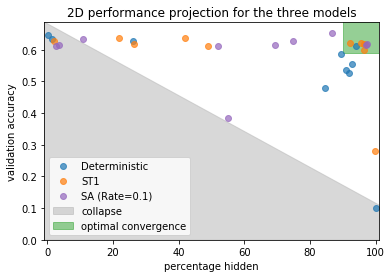

In [29]:
performance_projection_multiple([det_batch_logs, st1_batch_logs, sa_batch_logs],
                                [det_epoch_logs, st1_epoch_logs, sa_epoch_logs],
                                baseline=baseline,
                                labels=['Deterministic', 'ST1', 'SA (Rate=0.1)'],
                                colors=['C0', 'C1', 'C4'])

plt.title('2D performance projection for the three models')

## Fidelity-Interpretability Analysis

> Number of models collapsed due to low fidelity (i.e. Fidelity < 0.2)

In [30]:
fidelity_thres = 0.2
interpretability_thres = 0.

_, det_epoch_logs_nc = filter_logs_on_fi(det_batch_logs, det_epoch_logs, fidelity_thres, interpretability_thres)
_, st1_epoch_logs_nc = filter_logs_on_fi(st1_batch_logs, st1_epoch_logs, fidelity_thres, interpretability_thres)
_, sa_epoch_logs_nc = filter_logs_on_fi(sa_batch_logs, sa_epoch_logs, fidelity_thres, interpretability_thres)

print('Deterministic:    {}'.format(10 - len(det_epoch_logs_nc)))
print('Straight-Through: {}'.format(10 - len(st1_epoch_logs_nc)))
print('Slope-Annealing:  {}'.format(10 - len(sa_epoch_logs_nc)))

Deterministic:    1
Straight-Through: 0
Slope-Annealing:  0


> Number of models collapsed due to low Interpretability (i.e. Interp < 0.2)

In [31]:
fidelity_thres = 0.
interpretability_thres = 0.2

_, det_epoch_logs_nc = filter_logs_on_fi(det_batch_logs, det_epoch_logs, fidelity_thres, interpretability_thres)
_, st1_epoch_logs_nc = filter_logs_on_fi(st1_batch_logs, st1_epoch_logs, fidelity_thres, interpretability_thres)
_, sa_epoch_logs_nc = filter_logs_on_fi(sa_batch_logs, sa_epoch_logs, fidelity_thres, interpretability_thres)

print('Deterministic:    {}'.format(10 - len(det_epoch_logs_nc)))
print('Straight-Through: {}'.format(10 - len(st1_epoch_logs_nc)))
print('Slope-Annealing:  {}'.format(10 - len(sa_epoch_logs_nc)))

Deterministic:    2
Straight-Through: 2
Slope-Annealing:  4


> Total number of models collapsed (i.e. Interp < 0.2 and Fidelity < 0.2)

In [32]:
fidelity_thres = 0.2
interpretability_thres = 0.2

_, det_epoch_logs_nc = filter_logs_on_fi(det_batch_logs, det_epoch_logs, fidelity_thres, interpretability_thres)
_, st1_epoch_logs_nc = filter_logs_on_fi(st1_batch_logs, st1_epoch_logs, fidelity_thres, interpretability_thres)
_, sa_epoch_logs_nc = filter_logs_on_fi(sa_batch_logs, sa_epoch_logs, fidelity_thres, interpretability_thres)

print('Deterministic:    {}'.format(10 - len(det_epoch_logs_nc)))
print('Straight-Through: {}'.format(10 - len(st1_epoch_logs_nc)))
print('Slope-Annealing:  {}'.format(10 - len(sa_epoch_logs_nc)))

Deterministic:    3
Straight-Through: 2
Slope-Annealing:  4


> Mean Fidelity (non-collapsed models only)

In [33]:
print('Deterministic:    {:.2f}%'.format(np.mean([log['Fidelity'].iloc[-1] for log in det_epoch_logs_nc])))
print('Straight-Through: {:.2f}%'.format(np.mean([log['Fidelity'].iloc[-1] for log in st1_epoch_logs_nc])))
print('Slope-Annealing:  {:.2f}%'.format(np.mean([log['Fidelity'].iloc[-1] for log in sa_epoch_logs_nc])))

Deterministic:    0.86%
Straight-Through: 0.88%
Slope-Annealing:  0.90%


> Peak Fidelity (non-collapsed models only)

In [34]:
print('Deterministic:    {:.2f}%'.format(np.max([log['Fidelity'].iloc[-1] for log in det_epoch_logs_nc])))
print('Straight-Through: {:.2f}%'.format(np.max([log['Fidelity'].iloc[-1] for log in st1_epoch_logs_nc])))
print('Slope-Annealing:  {:.2f}%'.format(np.max([log['Fidelity'].iloc[-1] for log in sa_epoch_logs_nc])))

Deterministic:    0.96%
Straight-Through: 0.98%
Slope-Annealing:  1.00%


> Mean Interpretability (non-collapsed models only)

In [35]:
print('Deterministic:    {:.2f}%'.format(np.mean([log['Interpretability'].iloc[-1] for log in det_epoch_logs_nc])))
print('Straight-Through: {:.2f}%'.format(np.mean([log['Interpretability'].iloc[-1] for log in st1_epoch_logs_nc])))
print('Slope-Annealing:  {:.2f}%'.format(np.mean([log['Interpretability'].iloc[-1] for log in sa_epoch_logs_nc])))

Deterministic:    0.80%
Straight-Through: 0.65%
Slope-Annealing:  0.75%


> Peak Interpretability (non-collapsed models only)

In [36]:
print('Deterministic:    {:.2f}%'.format(np.max([log['Interpretability'].iloc[-1] for log in det_epoch_logs_nc])))
print('Straight-Through: {:.2f}%'.format(np.max([log['Interpretability'].iloc[-1] for log in st1_epoch_logs_nc])))
print('Slope-Annealing:  {:.2f}%'.format(np.max([log['Interpretability'].iloc[-1] for log in sa_epoch_logs_nc])))

Deterministic:    0.92%
Straight-Through: 1.00%
Slope-Annealing:  0.97%


In [37]:
[log[['Interpretability', 'Fidelity']].iloc[-1] for log in st1_epoch_logs_nc]

[Interpretability    0.219061
 Fidelity            0.975946
 Name: 78, dtype: float64, Interpretability    0.945913
 Fidelity            0.949622
 Name: 76, dtype: float64, Interpretability    0.997766
 Fidelity            0.429047
 Name: 99, dtype: float64, Interpretability    0.960397
 Fidelity            0.947201
 Name: 76, dtype: float64, Interpretability    0.487356
 Fidelity            0.936611
 Name: 72, dtype: float64, Interpretability    0.203429
 Fidelity            0.943873
 Name: 78, dtype: float64, Interpretability    0.411400
 Fidelity            0.973525
 Name: 74, dtype: float64, Interpretability    0.953844
 Fidelity            0.918457
 Name: 76, dtype: float64]

> Mean FIR (non-collapsed models only)

In [38]:
print('Deterministic:    {:.2f}%'.format(np.mean([log['FIR'].iloc[-1] for log in det_epoch_logs_nc])))
print('Straight-Through: {:.2f}%'.format(np.mean([log['FIR'].iloc[-1] for log in st1_epoch_logs_nc])))
print('Slope-Annealing:  {:.2f}%'.format(np.mean([log['FIR'].iloc[-1] for log in sa_epoch_logs_nc])))

Deterministic:    0.53%
Straight-Through: 0.60%
Slope-Annealing:  0.55%


> Mean FII (non-collapsed models only)

In [39]:
print('Deterministic:    {:.2f}%'.format(np.max([log['FIR'].iloc[-1] for log in det_epoch_logs_nc])))
print('Straight-Through: {:.2f}%'.format(np.max([log['FIR'].iloc[-1] for log in st1_epoch_logs_nc])))
print('Slope-Annealing:  {:.2f}%'.format(np.max([log['FIR'].iloc[-1] for log in sa_epoch_logs_nc])))

Deterministic:    0.79%
Straight-Through: 0.82%
Slope-Annealing:  0.64%


> Peak FII (non-collapsed models only)

In [40]:
print('Deterministic:    {:.2f}%'.format(np.max([log['FII'].iloc[-1] for log in det_epoch_logs_nc])))
print('Straight-Through: {:.2f}%'.format(np.max([log['FII'].iloc[-1] for log in st1_epoch_logs_nc])))
print('Slope-Annealing:  {:.2f}%'.format(np.max([log['FII'].iloc[-1] for log in sa_epoch_logs_nc])))

Deterministic:    0.85%
Straight-Through: 0.91%
Slope-Annealing:  0.92%


> Fewest epochs (non-collapsed models only)

In [41]:
def fewest_epochs(logs):
    return np.min([log['Interpretability'].apply(
        lambda x: np.nan if x == log['Interpretability'].iloc[-1] else x).count() for log in logs])

print('Deterministic:    ', fewest_epochs(det_epoch_logs_nc))
print('Straight-Through: ', fewest_epochs(st1_epoch_logs_nc))
print('Slope-Annealing:  ', fewest_epochs(sa_epoch_logs_nc))

Deterministic:     19
Straight-Through:  20
Slope-Annealing:   22


> Average epochs (non-collapsed models only)

In [42]:
def average_epochs(logs):
    return np.mean([log['Validation accuracy'].apply(
        lambda x: np.nan if x == log['Validation accuracy'].iloc[-1] else x).count() for log in logs])

print('Deterministic:    ', average_epochs(det_epoch_logs_nc))
print('Straight-Through: ', average_epochs(st1_epoch_logs_nc))
print('Slope-Annealing:  ', average_epochs(sa_epoch_logs_nc))

Deterministic:     38.285714285714285
Straight-Through:  31.625
Slope-Annealing:   37.5


A visual representation of the same things.

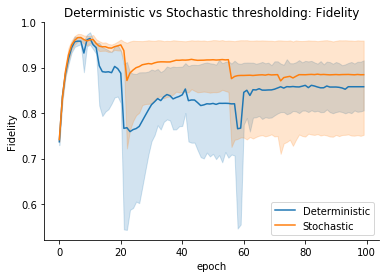

In [43]:
sns.lineplot(x='step', y='Fidelity', data=pd.concat(det_epoch_logs_nc), label='Deterministic')
sns.lineplot(x='step', y='Fidelity', data=pd.concat(st1_epoch_logs_nc), label='Stochastic')

plt.legend(loc='lower right')
plt.xlabel('epoch')

plt.title('Deterministic vs Stochastic thresholding: Fidelity')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

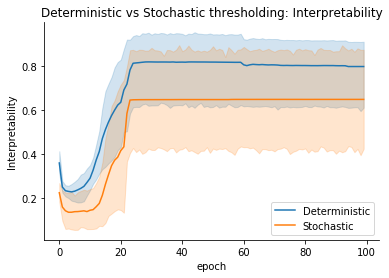

In [44]:
sns.lineplot(x='step', y='Interpretability', data=pd.concat(det_epoch_logs_nc), label='Deterministic')
sns.lineplot(x='step', y='Interpretability', data=pd.concat(st1_epoch_logs_nc), label='Stochastic')

plt.legend(loc='lower right')
plt.xlabel('epoch')

plt.title('Deterministic vs Stochastic thresholding: Interpretability')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

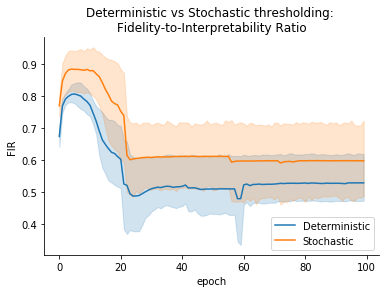

In [45]:
sns.lineplot(x='step', y='FIR', data=pd.concat(det_epoch_logs_nc), label='Deterministic')
sns.lineplot(x='step', y='FIR', data=pd.concat(st1_epoch_logs_nc), label='Stochastic')

plt.legend(loc='lower right')
plt.xlabel('epoch')

plt.title('Deterministic vs Stochastic thresholding: \nFidelity-to-Interpretability Ratio')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig('figures/deterministic_stochastic_fir.pdf', bbox_inches='tight', transparent=True)

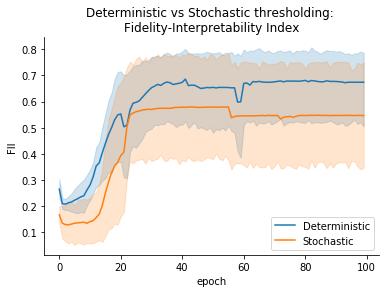

In [46]:
sns.lineplot(x='step', y='FII', data=pd.concat(det_epoch_logs_nc), label='Deterministic')
sns.lineplot(x='step', y='FII', data=pd.concat(st1_epoch_logs_nc), label='Stochastic')

plt.legend(loc='lower right')
plt.xlabel('epoch')

plt.title('Deterministic vs Stochastic thresholding: \nFidelity-Interpretability Index')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig('figures/deterministic_stochastic_fii.pdf', bbox_inches='tight', transparent=True)

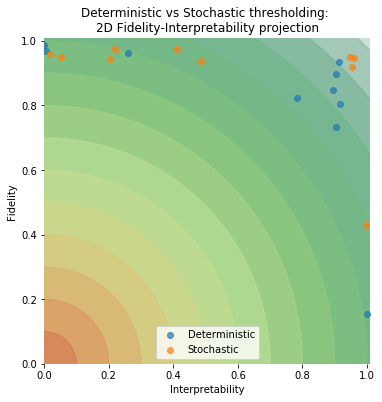

In [47]:
plt.figure(figsize=(6, 6))

fidelity_interpretability_projection([det_epoch_logs, st1_epoch_logs],
     baseline=0.7,
     labels=['Deterministic', 'Stochastic'],
     colors=['C0', 'C1'],
     max_fii=False)

plt.title('Deterministic vs Stochastic thresholding: \n2D Fidelity-Interpretability projection')

plt.savefig('figures/det_stoch_comparison_fi_2d.pdf', bbox_inches='tight', transparent=True)

## Discussion

### Definitions

As defined in previous notebooks:

> - There are two factors that come into play: **performance** (i.e. how high the accuracy was for a certain model) and **variance** (i.e. if we repeat the experiment how likely are we to expect the same performance.)
> - There are two types of variance we observed here. Variance of a single model for different values of alpha and the variance for training the same model more than once. When we use the term *variance* we'll refer to **both** types.
> - We want a model to have **high performance** (i.e. high accuracy) and **low variance** (i.e. few fluctuations in performance).
> - The performance of a trained seeker, on its own, will be referred to as the **baseline** performance. Obviously, because we are hiding information, the models aren't able to surpass this performance. It will serve as the upper limit for our experiments.
> - There are two extreme states that the model can get *locked* into, which provide suboptimal solutions:
> 
>     - The model doesn't hide anything, but classifies correctly.
>     - The model hides everything, but classifies randomly.
> 
>     These states will be referred to as **collapses**.

### Observations

- Stochastic models **collapsed fewer times** than deterministic ones.
- Stochastic models **achieved a much higher average and peak accuracy** than deterministic ones.
- Given the conditions we set for a successful training (i.e. at least 90% of baseline validation accuracy and 90% masking percentage), **stochastic models produced valid solutions slightly more frequently** than deterministic ones (i.e. 40% for stochastic 30% for deterministic).  
- Stochastic models managed a **slightly higher average and peak masking percentage**.
- Stochastic model were **more stable** and had a **lower variance** than deterministic ones.
- Stochastic models required fewer epochs in general to converge. However out of the models that did converge to valid solutions, **deterministic models converged faster**. 
- Out of the two stochastic estimators, slope annealing had a slightly better performance on classification, while straight-through achieved a slightly better masking percentage.

### Interpretations

Stochastic models, due to their nature, have a chance of masking any pixel on the image. This behaviour favours **exploration** during training, which leads to **more stable** models, **less prone to collapse**. There is little to none chance of a model converging to a solution where it either masks the entire image or none at all. Furthermore, they provide **better** solutions for both **masking** and **classification**.

Deterministic models, on the other hand, favour **exploitation**. This causes the models to **converge faster**, but generally score slightly lower, are less stable, have a higher variance and are more prone to collapse.

### Conclusions

- Stochastic models appear to be better than deterministic ones, mainly due to their **lower variance**.
- Out of the stochastic estimators, the *Straight-Through v1* and the *Slope-Annealing (Rate=1.0)* are the best, with little evidence to prefer one over the other. 